<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Theme 7. 순환 신경망
####(1) 기본 순환 신경망

In [2]:
# 주가 데이터(일자, 시작가, 고가, 저가, 종가, 보정된 종가, 거래량으로 구성됨) csv 파일로 시작
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/deeplearning/data/kospi.csv") # pandas 이용, csv 파일 데이터프레임 형태로 불러옴.
# 데이터는 보정된 종가 제외 나머지 사용, 일자 제외 MinMax 스케일 사용하여 데이터 가공
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [4]:
df.head() # head()는 상위 5개 항목에 대한 테이블 출력, 일자, 보정된 종가 제외 나머지가 스케일링 되었음.

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [5]:
# 데이터는 인스턴스 413개, 피쳐 4개(Open, High, Low, Volume)이고 타깃값은 종가(Close)임. 즉, 413X4 시계열 데이터 보유.
# 이 단계에서는 며칠을 사용하여 다음날 종가를 예측하느냐, 학습 데이터/평갸 데이터의 비율이 고려되어야함.
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
X = df[['Open','High','Low','Volume']].values # 데이터 프레임에서는 values를 이용하여 넘파이 배열로 만들 수 있다. X는 입력 데이터 
y = df['Close'].values # y는 타깃 데이터

In [6]:
def seq_data(x, y, sequence_length): # 시퀀스 데이터를 만드는 함수 생성
  x_seq = [] # x에 대한 시퀀스를 저장하는 빈 리스트
  y_seq = [] # y에 대한 시퀀스를 저장하는 빈 리스트
  for i in range(len(x)-sequence_length): # 미리 정한 시퀀스 길이로 쪼개어 저장. 데이터는 for문의 1회 당 한 칸 움직여 저장(보폭 정하는 것도 가능)
  # ex. 길이가 3이면 처음 저장된 데이터는 0, 1, 2번째 데이터가 한 묶음, 다음은 1, 2, 3, 그 다음은 2, 3, 4번째의 데이터가 한 묶음이 됨.
  # y 데이터는 다음 날 값이 타깃값 => 입력값이 x[i:i+sequence_length]면 타깃값은 y[i+sequence_length]로 작성.
  # ex. X가 0, 1, 2번째 데이터를 묶일 때 3번째 데이터의 y값이 대응되는 타깃값이 됨.
    x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1) # last, GPU용 텐서로 변환. 여기서 y 데이터를 view(-1,1)로 사용하여 2차원으로 바꾸는 이유 : MSE Loss가 기본적으로 2차원 타깃 데이터를 받기 때문.

In [7]:
split = 200 # 이때 순서대로 200개 데이터는 학습 데이터로 사용, 이후 데이터는 평가 데이터로 사용
sequence_length = 5 # 시퀀스 길이를 5로 설정, 426개의(431(전체 데이터)-5(시퀀스 길이)) 시퀀스 데이터 생성 가능.
x_seq, y_seq = seq_data(X,y,sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(),y_test_seq.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # This is added back by InteractiveShellApp.init_path()


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [9]:
# Dataset과 DataLoader를 이용, 배치 데이터로 만듦.
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)

In [10]:
# RNN 연산은 파이토치에서 제공하므로 전체를 직접 구현할 필요 X
input_size = x_seq.size(2) # 입력 변수의 개수
num_layers = 2 # 은닉층의 개수
hidden_size = 8 #은닉 상태를 저장하는 벡터의 크기
# 만 정하면 된다!

In [15]:
class VanillaRNN(nn.Module): # RNN의 클래스 생성
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__() # 각 변수 정리
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # nn.RNN을 이용하면 한 줄로 모델이 정의됨.
    # 주의할 점은 원래 nn.RNN의 입력 데이터 크기 = 시퀀스의 길이X배치사이즈X변수의 크기이므로, (200, 5, 4) 크기의 데이터 => (5, 200, 4)로 변경해야함.
    # But, batch_first=True 사용 시에는 기존의 200X5X4데이터를 그대로 사용 가능!
    self.fc = nn.Sequential(nn.Linear(hidden_size* sequence_length, 1), nn.Sigmoid()) # RNN에서 나온 출력값을 FC층 하나를 거쳐 예측값을 뽑을 수 있도록 self.fc 정의

  def forward(self,x):
    h0=torch.zeros(self.num_layers,x.size()[0], self.hidden_size).to(self.device) # RNN은 이전 h를 받아 계산 => 첫 번째 계산 시 이전 h가 없기 때문에 초깃값을 영텐서로 정의, h0를 대입.
    out,_=self.rnn(x,h0) # 정의된 self.rnn을 사용, 이때 파이토치에서 제공하는 모델은 many to many 방법을 가지고 각 시간에 대한 예측값 & 은닉 상태 산출. But 이 예시에서는 은닉 상태 사용 X, out,_으로 예측값을 받음.
    out = out.reshape(out.shape[0], -1) # 모든 출력값 사용을 위하여 out을 일렬로 만들어 self.fc에 넣음.
    out = self.fc(out)
    return out

In [16]:
# 입력값, 은닉 상태 크기, 시퀀스 길이, 은닉층 개수, gpu 연산을 위한 device 변수까지 모델에 넣어줌. 또한 GPU 연산을 위해 moodel 뒤에 .to(device)를 붙여줌.
model = VanillaRNN(input_size = input_size,
                   hidden_size = hidden_size,
                   sequence_length = sequence_length,
                   num_layers = num_layers,
                   device = device).to(device)

In [17]:
# 주가 예측 => 회귀문제 => 대표적인 MSE 손실 함수 사용. 학습은 301회, 최적화 방법은 Adam.
criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [18]:
# 그저 전형적인 지도 학습 방법
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터
    out = model(seq) # 출력값 산출
    loss = criterion(out, target) # 손실 함수 계산


    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # 최적화
    running_loss+=loss.item()

  loss_graph.append(running_loss/n)
  if epoch%100==0:
    print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0212
[epoch: 100] loss: 0.0009
[epoch: 200] loss: 0.0006
[epoch: 300] loss: 0.0004


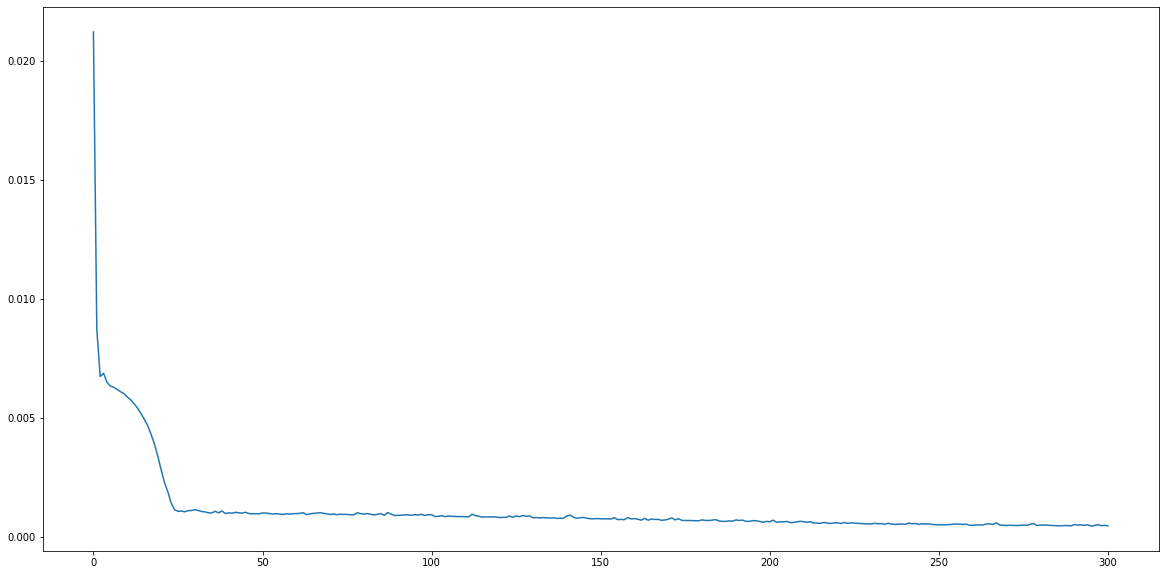

In [19]:
# 손실 함수를 통해 단편적으로 훈련이 잘 됐음을 확인 할 수 있음!
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

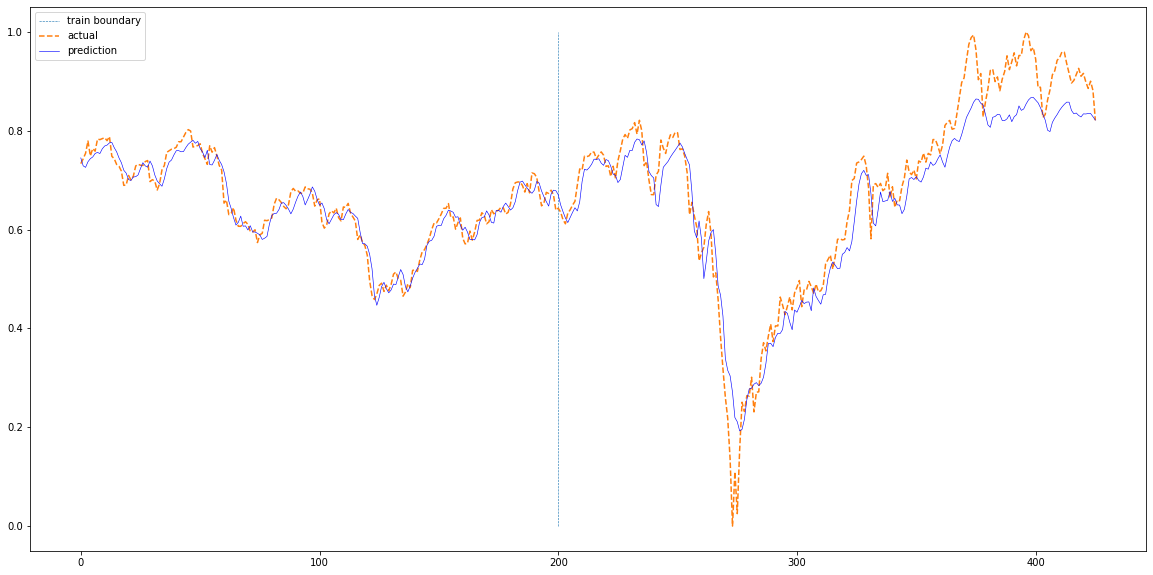

In [22]:
concatdata = torch.utils.data.ConcatDataset([train,test]) # ConcatDataset은 여러 개의 데이터 세트를 함께 사용할 수 있도록 도와줌.
# 입력값은 데이터 세트의 리스트를 받음 => 앞서 정의한 train, test를 리스트 [train, test]로 넣어줌.
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100)
with torch.no_grad():
  pred = [] # 예측값을 저장할 빈 텐서 pred 생성
  model.eval()
  for data in data_loader:
    seq,target = data
    out = model(seq)
    pred+=out.cpu().tolist() # 예측값은 GPU 텐서 => CPU 텐서로 변환 후 .tolist()를 이용, 리스트로 만들어 순차적으로 리스트 이어 붙임.
plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--',linewidth=0.6) # 학습, 평가 일수를 구분짓는 선을 그음.
plt.plot(df['Close'][sequence_length:].values,'--') # 실제값
plt.plot(pred,'b',linewidth=0.6) # 예측값
plt.legend(['train boundary','actual','prediction'])
plt.show()
# 파란색 수직선을 기준으로 왼쪽을 훈련 데이터, 오른쪽을 평가 데이터로 사용 => 훈련 데이터 부분은 학습이 잘 되어 실제값과 예측값이 잘 맞는듯?
# 평가 부분은 급락하는 부분을 못잡아냄. 예측을 잘 하는거 같으나 오른쪽으로 shift 되었음.

####(2) LSTM과 GRU

#####2. LSTM

In [3]:
# 모델 구축 부분 제외, RNN 코드와 동일
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layer = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # nn.LSTM을 통해 한줄로 정의, LSTM은 은닉 상태, 셀 상태를 계산, 다음 타임 스텝으로 넘겨줌.
    self.fc = nn.Linear(hidden_size*sequence_length,1)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 은닉 상태, 셀 상태의 초깃값은 0, 모델에 넣어줌.
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out,_ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

#####3. GRU(Gated Recurrent Units)

In [4]:
# 역시 모델 구축 외 다른 부분은 RNN 코드와 동일!
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(GRU,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # 마찬가지로 nn.GRU를 통해 한 줄로 정의 가능.
    self.fc = nn.Linear(hidden_size*sequence_length,1)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) # RNN과 마찬가지로 은닉 상태의 초깃값은 0.
    out,_ = self.gru(x,h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

####(3) Bi-LSTM

#####1. Bi-LSTM 구현하기

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [6]:
# 본 예시에서는 숫자 이미지 판별을 양방햔 LSTM을 통해 예측 할 것. 
# 우리가 다루는 이미지는 주로 (배치사이즈, 채널 수, 이미지 너비, 이미지 높이) 형태의 크기를 지니고 있음.
# MNIST 데이터의 채널 수는 1이고 이미지 크기가 28X28임. => 각 배치 데이터의 크기 = (배치사이즈, 1, 28, 28) => (배치사이즈, 28, 28)
# 또한, 이미지 픽셀의 각 열을 하나의 벡터로 보고 행을 타임 스텝으로 볼 시 (배치사이즈, 시계열의 길이, 벡터의 크기)를 가진 시계열 데이터로 판단 가능. => 순환 신경망도 이미지 처리에 활용될 수 있다.
tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root="/content/drive/MyDrive/deeplearning/data", train=True, transform=tensor_mode,
                                      download=True)
testset = torchvision.datasets.MNIST(root="/content/drive/MyDrive/deeplearning/data", train=False, transform=tensor_mode,
                                     download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/deeplearning/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/deeplearning/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/deeplearning/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/deeplearning/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/deeplearning/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/deeplearning/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/deeplearning/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/deeplearning/data/MNIST/raw



In [7]:
class BiLSTM(nn.Module): # BiLSTM 클래스 정의
  def __init__(self,input_size,hidden_size,num_layers,seq_length,num_classes,device): # 입력값의 크기(이미지의 열 크기), 은닉층의 노드수, 은닉층의 개수, 시계열의 길이, 클래스 수, gpu 활용 여부에 대한 값을 받음.
    super(BiLSTM,self).__init__()
    self.device=device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True,
                        bidirectional=True) # bidirectional=True로 활성화, 양방향 LSTM을 생성, batch_first = True로 지정, 크기가 (배치 사이즈, 시계열의 길이, 입력값의 크기)를 지닌 데이터를 활용할 수 있도록 함.
    self.fc = nn.Linear(seq_length*hidden_size*2, num_classes) # 모든 타임 스탭에 대한 LSTM 결과를 분류에 사용 => self.fc의 입력값의 크기는 시계열의 길이*은닉층의 크기*2.
    # 양방향 LST은 정방향, 역방향에 대한 LSTM을 계산한 후 합친 결과를 사용 => 각각의 은닉층 결과 2개가 합쳐지므로 2를 곱하는 것.
  def forward(self,x):
    h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device) # 은닉 상태와 셀 상태의 초깃값 정의. 여기서도 양방향에 대한 초깃값을 지정해야함 => 은닉층의 개수에 2를 곱함.
    c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
    out,_ = self.lstm(x,(h0,c0)) # 모델에서 나온 out의 크기는 (배치사이즈, 시계열의 길이, 은닉층의 노드수*2)임. 모든 데이터를 nn.Linear에 사용하기 위해 reshape를 하여 크기를 (배치사이즈, 시계열의 길이*은닉층의 노드수*2)로 변경
    out = out.reshape(-1,self.seq_length*self.hidden_size*2)
    out = self.fc(out) # 마지막으로 self.fc를 거친 후 크기가 10인 출력 벡터를 산출.
    return out

In [8]:
# 모델에 필요한 변수 정의. 위에서 언급했듯이 이미지 데이터의 행을 시계열로 열을 입력 벡터로 활용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = trainset.data.size(1) # 시계열의 길이는 trainset.data.size(1), 입력 벡터의 크기는 trainset.data.size(2).
input_size = trainset.data.size(2)
num_layers = 2 # Bi-LSTM의 은닉층 정보 => 적절한 값을 넣어줌.
hidden_size = 12
num_classes = 10 # 클래스 수는 10.

In [9]:
# 모델, 손실 함수, 최적화 기법 정의
model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [10]:
# 학습 방법은 지금까지와 동일.
for epoch in range(51):
  correct = 0
  total = 0
  for data in trainloader:
    optimizer.zero_grad()
    inputs, labels = data[0].to(device).squeeze(1), data[1].to(device) # 다만 원래 배치 데이터의 크기가 (배치사이즈, 1, 28, 28) => squeeze(1)을 통해 데이터의 크기를 (배치사이즈, 28, 28)로 변환
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _,predicted = torch.max(outputs.detach(), 1) # 학습 도중 정확도를 구할 때에는 변수 업데이트 필요 X, detach()을 사용, outputs의 requires_grad 비활성화.
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
  print('[%d] train acc: %.2f'%(epoch,100*correct/total))

[0] train acc: 91.50
[1] train acc: 97.38
[2] train acc: 98.18
[3] train acc: 98.50
[4] train acc: 98.74
[5] train acc: 98.94
[6] train acc: 98.98
[7] train acc: 99.16
[8] train acc: 99.17
[9] train acc: 99.33
[10] train acc: 99.27
[11] train acc: 99.41
[12] train acc: 99.38
[13] train acc: 99.54
[14] train acc: 99.50
[15] train acc: 99.55
[16] train acc: 99.57
[17] train acc: 99.62
[18] train acc: 99.61
[19] train acc: 99.61
[20] train acc: 99.65
[21] train acc: 99.66
[22] train acc: 99.62
[23] train acc: 99.72
[24] train acc: 99.67
[25] train acc: 99.71
[26] train acc: 99.75
[27] train acc: 99.69
[28] train acc: 99.64
[29] train acc: 99.77
[30] train acc: 99.75
[31] train acc: 99.78
[32] train acc: 99.66
[33] train acc: 99.77
[34] train acc: 99.78
[35] train acc: 99.72
[36] train acc: 99.87
[37] train acc: 99.78
[38] train acc: 99.71
[39] train acc: 99.86
[40] train acc: 99.75
[41] train acc: 99.76
[42] train acc: 99.84
[43] train acc: 99.83
[44] train acc: 99.80
[45] train acc: 99.8

In [11]:
# 순환 신경망을 통해 98.6%의 평가 정확도 달성. 이와 같이 순환 신경망을 이미지 처리에 사용 가능.
def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs,labels = data[0].to(device).squeeze(1), data[1].to(device)
      outputs = model(inputs)
      _,predicted = torch.max(outputs,1)
      total+=labels.size(0)
      correct+=(predicted==labels).sum().item()

    acc = 100*correct/total
    model.train()
    return acc

In [12]:
train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)
print("Train Acc: %.1f, Test Acc:%.1f"%(train_acc, test_acc))

Train Acc: 99.8, Test Acc:98.6
